In [1]:
!pip install konlpy
!pip install koeda
!pip install matplotlib
!pip install seaborn

In [2]:
# AEDA 사용방법
from koeda import AEDA

aeda = AEDA(
    morpheme_analyzer="Okt", punc_ratio=0.3, punctuations=[".", ",", "!", "?", ";", ":"]
)

text = "어머니가 집을 나가신다"

result = aeda(text)
print(result)

어머니 : 가 집을 나가신다


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv("./train.csv")

#### ver1,2 만들 때는 중복데이터 삭제하는 거 까먹음
### 중복 데이터 제거

In [5]:
train_is_duplicated = train.duplicated(subset=["sentence", "subject_entity", "object_entity"], keep=False)
df_duplicated = train.loc[train_is_duplicated, :]
df_duplicated.sort_values(by=["sentence"])
train_drop= train.drop_duplicates(subset=["sentence", "subject_entity", "object_entity"]).reset_index(drop=True)
train_drop

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32418,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree
32419,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia
32420,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32421,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


### 각 라벨 별로 문장의 개수 정보 저장

AEDA를 할 때 고려해야할 점:
1. 만약 entity 자리에 문장 기호가 들어간다면 정확도가 낮아지지 않을까?
2. per:place_of_death는 40개, no_relation은 9516개로 편차가 큰데 몇 개를 기준으로 증강해야 할까?

=> 데이터가 정말 부족한 하위 다섯개만 증강

In [6]:
from collections import defaultdict
label_num = defaultdict(int)
idx_1 = [] # "per:place_of_death"
idx_2 = [] # "org:number_of_employees/members"
idx_3 = [] # 'org:dissolved'
idx_4 = [] # 'per:schools_attended'
idx_5 = [] # 'per:religion'

for i in range(32423):
    label_num[train_drop['label'][i]] += 1
    if train_drop['label'][i] == "per:place_of_death":
        idx_1.append(i)
    elif train_drop['label'][i] == "org:number_of_employees/members":
        idx_2.append(i)
    elif train_drop['label'][i] == 'org:dissolved':
        idx_3.append(i)
    elif train_drop['label'][i] == 'per:schools_attended':
        idx_4.append(i)
    elif train_drop['label'][i] == 'per:religion':
        idx_5.append(i)
        
print(label_num)
#print(idx_1)

defaultdict(<class 'int'>, {'no_relation': 9516, 'org:member_of': 1864, 'org:top_members/employees': 4278, 'org:alternate_names': 1318, 'per:date_of_birth': 1130, 'org:place_of_headquarters': 1194, 'per:employee_of': 3567, 'per:origin': 1234, 'per:title': 2098, 'org:members': 420, 'per:schools_attended': 82, 'per:colleagues': 534, 'per:alternate_names': 997, 'per:spouse': 795, 'org:founded_by': 155, 'org:political/religious_affiliation': 98, 'per:children': 304, 'org:founded': 450, 'org:number_of_employees/members': 48, 'per:place_of_birth': 166, 'org:dissolved': 66, 'per:parents': 518, 'per:religion': 96, 'per:date_of_death': 417, 'per:place_of_residence': 193, 'per:other_family': 190, 'org:product': 380, 'per:siblings': 136, 'per:product': 139, 'per:place_of_death': 40})


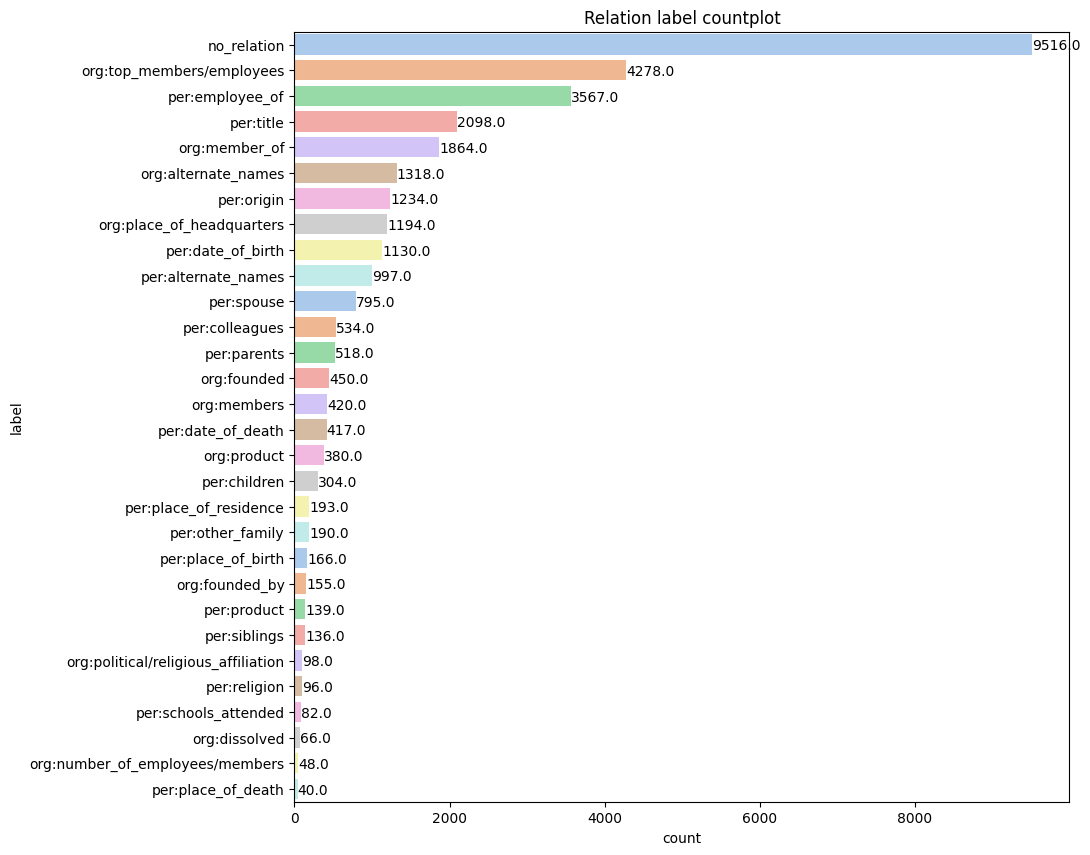

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.countplot(y='label', data=train_drop, palette = sns.color_palette("pastel"), 
                    order = train_drop['label'].value_counts().index, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + 0.6), fontsize=10)
plt.title("Relation label countplot")
plt.show()

In [8]:
train_1 = train.iloc[idx_1]

for i in idx_1:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_1['sentence'][i] = aeda(train_1['sentence'][i])

train_1

C:\Users\2jeon\AppData\Local\Temp\ipykernel_15368\1812588486.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1['sentence'][i] = aeda(train_1['sentence'][i])


,id,sentence,subject_entity,object_entity,label,source
1044,1044,"2010년 3월 29일, 최진영은 서울특별시 강남구 논현동의 ; 자택에서 ! 스스로...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
1552,1552,"? 막시밀리아노 1세 ; (Maximiliano I, , 1832년 7월 6일 , ...","{'word': '막시밀리아노 1세', 'start_idx': 0, 'end_idx...","{'word': '멕시코 케레타로', 'start_idx': 60, 'end_idx...",per:place_of_death,wikipedia
2214,2214,을미사변 때 훈련대 병력을 동원하여 명성황후를 시해하는 데 동참했던 당시 조선훈련대...,"{'word': '우범선', 'start_idx': 205, 'end_idx': 2...","{'word': '일본 히로시마현 구레', 'start_idx': 176, 'end...",per:place_of_death,wikipedia
2802,2802,마리 드 메디시스 왕비는 . 1630년 그녀의 아들이었던 : 루이 13 ! 세에 의...,"{'word': '마리 드 메디시스', 'start_idx': 0, 'end_idx...","{'word': '쾰른', 'start_idx': 71, 'end_idx': 72,...",per:place_of_death,wikipedia
3509,3509,제5공화국 당시 민주정의당의 국회의원이었다가 1998년 새정치국민회의에 입당하여 새...,"{'word': '새정치국민회의', 'start_idx': 31, 'end_idx'...","{'word': '김대중', 'start_idx': 61, 'end_idx': 63...",no_relation,wikipedia
4169,4169,"대안 , 정치 . 연대 최경환 의원 , (광주 북구 ! 을, 문화체육관광위원회)이 ...","{'word': '대안정치', 'start_idx': 0, 'end_idx': 3,...","{'word': '최경환', 'start_idx': 7, 'end_idx': 9, ...",no_relation,wikitree
4419,4419,"빨치산 시절 김일성의 전령병이었던 ? 이을설(李乙雪, 1921-2015)도 김일성이...","{'word': '이을설', 'start_idx': 19, 'end_idx': 21...","{'word': '김일성', 'start_idx': 40, 'end_idx': 42...",per:colleagues,wikipedia
4947,4947,"이어 ! 당시 장로교에서는 송창근, 김재준, 채필근, 한경직 목사도 이에 찬동하여 ...","{'word': '한경직', 'start_idx': 28, 'end_idx': 30...","{'word': '장로교', 'start_idx': 6, 'end_idx': 8, ...",per:religion,wikipedia
7226,7226,"2004년 12월부터 흥안운수와 한성 , 여객에서 운행하다가 흥안운수는 2014년,...","{'word': '한성여객', 'start_idx': 18, 'end_idx': 2...","{'word': '흥안운수', 'start_idx': 31, 'end_idx': 3...",no_relation,wikipedia
7437,7437,1949년 ; 10월 한국민주당 . 의 ? 후신인 ; 민주국민당(약칭 : 민국당) ...,"{'word': '민주국민당', 'start_idx': 21, 'end_idx': ...","{'word': '민주당', 'start_idx': 12, 'end_idx': 14...",org:alternate_names,wikipedia


In [9]:
train_2 = train.iloc[idx_2]

for i in idx_2:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_2['sentence'][i] = aeda(train_2['sentence'][i])

train_2

C:\Users\2jeon\AppData\Local\Temp\ipykernel_15368\679507187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['sentence'][i] = aeda(train_2['sentence'][i])


KeyboardInterrupt: 

In [ ]:
train_3 = train.iloc[idx_3]

for i in idx_3:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_3['sentence'][i] = aeda(train_3['sentence'][i])

train_3

In [ ]:
train_4 = train.iloc[idx_4]

for i in idx_4:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_4['sentence'][i] = aeda(train_4['sentence'][i])

train_4

In [ ]:
train_5 = train.iloc[idx_5]

for i in idx_5:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_5['sentence'][i] = aeda(train_5['sentence'][i])

train_5

In [ ]:
result = pd.concat([train, train_1, train_2,train_3,train_4,train_5])
result

In [ ]:
result.to_csv('./train_aug_ver3.csv', index=False)